**g16**
- anderdav@students.zhaw.ch
- goodnic1@students.zhaw.ch
- janick.rueegger@students.fhnw.ch
- neyerjoh@students.zhaw.ch

# Exercise 4: Confusion Matrix

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

### Load Data

For the example's sake we here don't split further in a validation set. Just compute the confusion matrix based on prediction for the test data.

In [2]:
training_data = datasets.mnist.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.MNIST(root="data", train=False, download=True, transform=ToTensor())


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Model

Specify your favorite MLP as determined in one of the previous execises.

In [3]:
def get_model(complexity=200, drop_p_in=.2, drop_p_hidden=.5):
    return torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Dropout(p=drop_p_in),
        torch.nn.Linear(28*28, complexity),
        torch.nn.Sigmoid(),
        torch.nn.Dropout(p=drop_p_hidden),
        torch.nn.Linear(complexity, 10),
        torch.nn.Sigmoid())

model = get_model(complexity=300, drop_p_in=0.3, drop_p_hidden=0.3)

In [4]:
summary(model, (1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Dropout: 1-2                           [-1, 784]                 --
├─Linear: 1-3                            [-1, 300]                 235,500
├─Sigmoid: 1-4                           [-1, 300]                 --
├─Dropout: 1-5                           [-1, 300]                 --
├─Linear: 1-6                            [-1, 10]                  3,010
├─Sigmoid: 1-7                           [-1, 10]                  --
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
Total mult-adds (M): 0.24
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.91
Estimated Total Size (MB): 0.92


Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Dropout: 1-2                           [-1, 784]                 --
├─Linear: 1-3                            [-1, 300]                 235,500
├─Sigmoid: 1-4                           [-1, 300]                 --
├─Dropout: 1-5                           [-1, 300]                 --
├─Linear: 1-6                            [-1, 10]                  3,010
├─Sigmoid: 1-7                           [-1, 10]                  --
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
Total mult-adds (M): 0.24
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.91
Estimated Total Size (MB): 0.92

### Train-Validate

Specify the training / evaluation loop. Specifically, make sure that the confusion matrix is computed at the end of every epoch and remember it. 

In [15]:
def train_eval(model, lr, nepochs, nbatch, training_data, test_data):
    training_cost_hist = []; test_cost_hist = [];
    test_acc_hist = []; training_acc_hist = [];
    test_cm_hist = []

    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)
    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    
    print("Epoch\t Train Costs\t Test Costs\t Train Accuracy\t Test Accuracy")
    for epoch in range(nepochs):
        model.train()
        training_cost, correct = 0.0, 0.0
        for inputs, targets in training_loader:
            predictions = model(inputs)
            cost = cost_ce(predictions, targets)
            training_cost += cost.item()
            correct += (predictions.argmax(dim=1) == targets).type(torch.float).sum().item()
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        training_cost /= len(training_loader)
        training_acc = correct / len(training_loader.dataset)

        model.eval()
        test_cost, test_acc = 0.0, 0.0
        with torch.no_grad():
            inputs, targets = next(iter(test_loader))
            predictions = model(inputs)
            test_cost = cost_ce(predictions, targets).item()
            test_acc = (torch.argmax(predictions, dim=1) == targets).float().mean().item()
        
        cm = confusion_matrix(targets, torch.argmax(predictions, dim=1))
        test_cm_hist.append(cm)
        
        training_cost_hist.append(training_cost)
        training_acc_hist.append(training_acc)
        test_cost_hist.append(test_cost)
        test_acc_hist.append(test_acc)
        print("{:2}\t {:.2f}\t\t {:.2f}\t\t {:.2f}\t\t {:.2f}"
              .format(epoch, training_cost, test_cost, training_acc, test_acc))
    
    return training_cost_hist, test_cost_hist, training_acc_hist, test_acc_hist, test_cm_hist

### Select your favourite settings and Do the Training incl Validation Performance

In [16]:
# Configuration options
nepochs = 20
lr = 0.5
nbatch = 64

In [17]:
_, _, _, _, test_cm_hist = train_eval(model, lr, nepochs, nbatch, training_data, test_data)

Epoch	 Train Costs	 Test Costs	 Train Accuracy	 Test Accuracy
 0	 1.55		 1.53		 0.91		 0.93
 1	 1.55		 1.52		 0.91		 0.93
 2	 1.55		 1.52		 0.91		 0.93
 3	 1.55		 1.52		 0.91		 0.94
 4	 1.54		 1.52		 0.91		 0.94
 5	 1.54		 1.52		 0.92		 0.94
 6	 1.54		 1.52		 0.92		 0.94
 7	 1.54		 1.52		 0.92		 0.94
 8	 1.54		 1.52		 0.92		 0.94
 9	 1.54		 1.51		 0.92		 0.94
10	 1.53		 1.51		 0.92		 0.94
11	 1.53		 1.51		 0.93		 0.95
12	 1.53		 1.51		 0.93		 0.95
13	 1.53		 1.51		 0.93		 0.95
14	 1.53		 1.51		 0.93		 0.95
15	 1.53		 1.51		 0.93		 0.95
16	 1.53		 1.51		 0.93		 0.95
17	 1.53		 1.51		 0.93		 0.95
18	 1.53		 1.51		 0.93		 0.95
19	 1.53		 1.51		 0.93		 0.95


### Inspect Confusion Matrix

In the given implementation below, we use seaborn for depicting the confusion matrix as a heat map. Hence, make sure to have that installed in your environment.

Note that the heatmap includes two different color scheme - one for the diagonal, one for the off-diagonal elements. 

In [21]:
import seaborn as sn

def display_cm(cf_matrix, title):
    plt.figure(figsize = (12,7))
    off_diag_mask = np.eye(*cf_matrix.shape, dtype=bool)
    cm = cf_matrix / np.sum(cf_matrix) * 10
    vmin = np.min(cm[~off_diag_mask])
    vmax = np.max(cm[~off_diag_mask])
    sn.heatmap(cm, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, cbar_kws=dict(ticks=[]))
    plt.ylabel("label")
    plt.xlabel("prediction")
    vmin = np.min(cm[off_diag_mask])
    vmax = np.max(cm[off_diag_mask])
    sn.heatmap(cm, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax)
    plt.ylabel("label")
    plt.xlabel("prediction")
    plt.title(title)
    #df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in range(10)], columns = [i for i in range(10)])
    #sn.heatmap(df_cm, annot=True, cmap='Blues')


<Figure size 432x288 with 0 Axes>

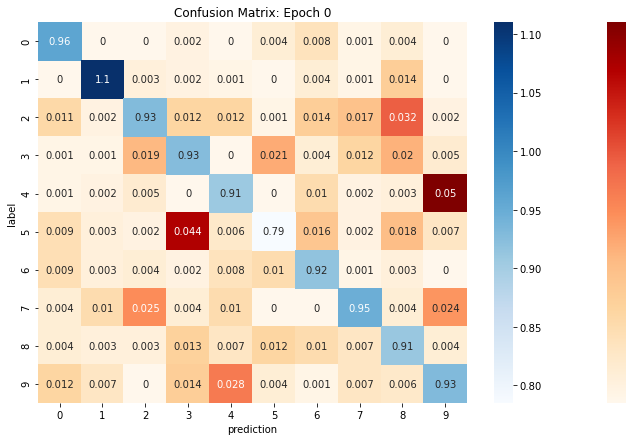

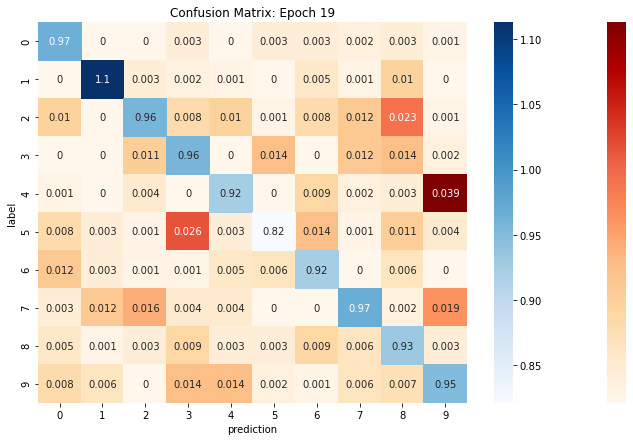

In [22]:
plt.figure(1)
display_cm(test_cm_hist[0], "Confusion Matrix: Epoch 0")

plt.figure(2)
display_cm(test_cm_hist[19], "Confusion Matrix: Epoch 19")

### Interpret!

Analyse how the CM evolves. Indicate what remains a problem for the model to properly classify.


#### Intepretation

Starting in epoch 0, the model already provides petty good results (min TP > 0.79). It's impressive that it gets so much right after only one epoch though. It's main issues lay in misclassification of `4` as `9`, `5` as `3`, and `2` as `8`.

After 20 epochs, it gets even better (min TP > 0.82). However, looking at the two confusion matrices, it does not seem like the model improved much. The stated issues from epoch 0 remain to a large degree, even though they improve by 1-2 percent.

### Compute Accuracy, Precision, Recall

In [23]:
cm = test_cm_hist[19]
cm = cm / np.sum(cm) * 10
cm_diag = cm.diagonal()

In [26]:
print("class accuracy")
for i, v in enumerate(cm_diag):
    print(f"{i}: {v:.3}")

print(f"overall accuracy: {cm_diag.mean():.3}")

class accuracy
0: 0.965
1: 1.11
2: 0.959
3: 0.957
4: 0.924
5: 0.821
6: 0.924
7: 0.968
8: 0.932
9: 0.951
overall accuracy: 0.951


In [25]:
print("class recall")
recall_sum = 0.0
for i in range(len(cm_diag)):
    recall = cm_diag[i] / cm[[i], :].sum()
    print(f"{i}: {recall:.3}")
    recall_sum += recall

print(f"system recall: {(recall_sum / len(cm_diag)):.3}")

class recall
0: 0.985
1: 0.981
2: 0.929
3: 0.948
4: 0.941
5: 0.92
6: 0.965
7: 0.942
8: 0.957
9: 0.943
system recall: 0.951


In [103]:
print("class precision")
precision_sum = 0.0
for i in range(len(cm_diag)):
    precision = cm_diag[i] / cm[:, [i]].sum()
    print(f"{i}: {precision:.3}")
    precision_sum += precision

print(f"system precision: {(precision_sum / len(cm_diag)):.3}")

class precision
0: 0.948
1: 0.971
2: 0.949
3: 0.926
4: 0.916
5: 0.95
6: 0.934
7: 0.949
8: 0.891
9: 0.935
system recall: 0.937
